# Speaker diarization

Speaker diarization is the process of partitioning an audio stream containing human speech into homogeneous segments according to the identity of each speaker. It can enhance the readability of an automatic speech transcription by structuring the audio stream into speaker turns and, when used together with speaker recognition systems, by providing the speaker’s true identity. It is used to answer the question "who spoke when?"

![image.png](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_images/asr_sd_diagram.png)

With the increasing number of broadcasts, meeting recordings and voice mail collected every year, speaker diarisation has received much attention by the speech community. Seaker diarization is an essential feature for a speech recognition system to enrich the transcription with speaker labels.

In this tutorial we consider how to build speaker diarization pipeline using pyannote.audio and OpenVINO. `pyannote.audio`is an open-source toolkit written in Python for speaker diarization. Based on PyTorch deep learning framework, it provides a set of trainable end-to-end neural building blocks that can be combined and jointly optimized to build speaker diarization pipelines. You can find more information about pyannote pretrained models in [model card](https://huggingface.co/pyannote/speaker-diarization), [repo](https://github.com/pyannote/pyannote-audio) and [paper](https://arxiv.org/abs/1911.01255).

## Prerequisites

In [ ]:
!pip install -r requirements.txt

## Prepare pipeline

Traditional Speaker Diarization systems can be generalised into a 5 step process:
   * **Feature extraction**: transform the raw waveform into audio features like mel spectrogram.
   * **Voice activity detection**: identify the chunks in the audio where some voice activity was observed. As we are not interested in silence and noise, we ignore those irrelevant chunks.
   * **Speaker change detection**: identify the speaker changepoints in the conversation present in the audio.
   * **Speech turn representation**: encode each subchunk by creating feature representations.
   * **Speech turn clustering**: cluster the subchunks based on their vector representation. Different clustering algorithms could be applied based on availability of cluster count (k) and embedding process of the previous step.

The final output will be the clusters of different subchunks from the audio stream. Each cluster can be given an anonymous identifier (speaker_a, ..) and then it can be mapped with the audio stream to create the speaker aware audio timeline.

On the diagram you can see typical speaker diarization pipeline:

![diarization_pipeline](http://mohitmayank.com/a_lazy_data_science_guide/imgs/audio_speakerdiarization_intro.png)

From simplified point of view, speaker diarization is a combination of speaker segmentation and speaker clustering. The first aims at finding speaker change points in an audio stream. The second aims at grouping together speech segments on the basis of speaker characteristics.

For instantiating speaker diarization pipeline with `pyannote.audio` library, we should import `Pipeline` class and use `from_pretrained` method with providing path to directory with pipeline configuration or identificator from [HuggingFace hub](https://huggingface.co/pyannote/speaker-diarization).

>**Note**:
> This tutorial uses non-official version of model `philschmid/pyannote-speaker-diarization-endpoint`, provided only for demo purpoces.
> The original model (`pyannote/speaker-diarization`) requires you to accept the model license before downloading or using its weights, visit the [pyannote/speaker-diarization](https://huggingface.co/pyannote/speaker-diarization) to read accept the license before you proceed.
>To use this model, you must be a registered user in 🤗 Hugging Face Hub. You will need to use an access token for the code below to run. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).
>You can login on HuggingFace Hub in notebook environment using following code:
```python
## login to huggingfacehub to get access to pretrained model 
from huggingface_hub import notebook_login, whoami

try:
    whoami()
    print('Authorization token already provided')
except OSError:
    notebook_login()
```


In [2]:
from pyannote.audio import Pipeline

pipeline = Pipeline.from_pretrained("philschmid/pyannote-speaker-diarization-endpoint")

## Load test audio file

In [3]:
import sys

sys.path.append("../utils")

from notebook_utils import download_file

test_data_url = "https://github.com/pyannote/pyannote-audio/raw/develop/tests/data/tst01.wav"

download_file(test_data_url, 'tst01.wav')
AUDIO_FILE = {'uri': 'tst01', 'audio': 'tst01.wav'}

'tst01.wav' already exists.


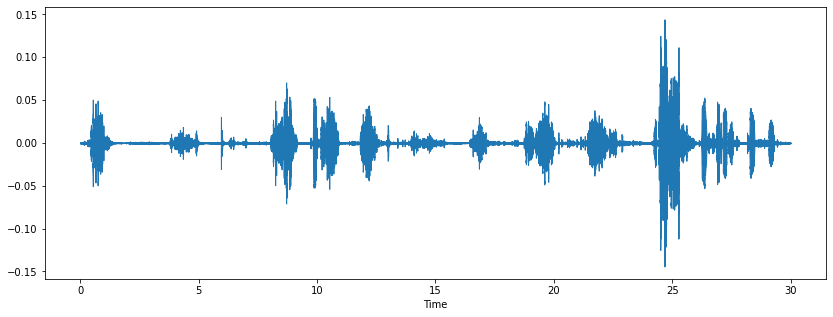

In [5]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd


audio, sr = librosa.load('tst01.wav')
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)

ipd.Audio('tst01.wav')

## Run inference pipeline

For running inference we should provide path to input audio to the pipeline

In [5]:
%%capture
import time

start = time.perf_counter()
diarization = pipeline(AUDIO_FILE)
end = time.perf_counter()

In [6]:
print(f"Diarization pipeline took {end - start:.2f} s")

Diarization pipeline took 5.65 s


The result of running pipeline can be represented as diagram indicates when each speaker speaks

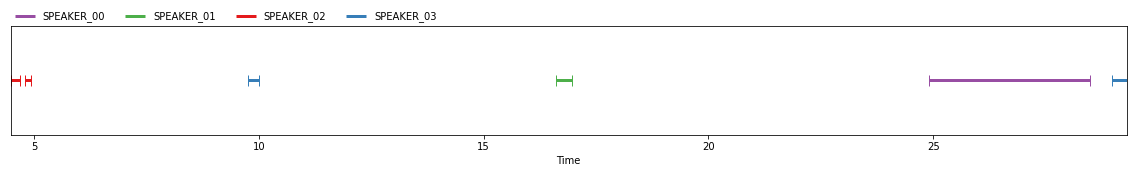

In [7]:
diarization

We also can print each time frame and corresponding speaker:

In [8]:
for turn, _, speaker in diarization.itertracks(yield_label=True):
    print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")

start=4.5s stop=4.7s speaker_SPEAKER_02
start=4.8s stop=4.9s speaker_SPEAKER_02
start=9.8s stop=10.0s speaker_SPEAKER_03
start=16.6s stop=17.0s speaker_SPEAKER_01
start=24.9s stop=28.5s speaker_SPEAKER_00
start=29.0s stop=29.3s speaker_SPEAKER_03


## Convert model to OpenVINO Intermediate Representation format

For best results with OpenVINO we recommend converting the model to OpenVINO IR format. OpenVINO supports PyTorch via ONNX conversion. We will use `torch.onnx.export` for exporting the ONNX model from PyTorch. We need to provide initialized model object and example of inputs for shape inference. We will use `mo.convert_model` functionality to convert the ONNX models. The `mo.convert_model` Python function returns an OpenVINO model ready to load on device and start making predictions. We can save it on disk for next usage with `openvino.runtime.serialize`.

In [9]:
from pathlib import Path
import torch
from openvino.tools import mo
from openvino.runtime import serialize, Core

core = Core()

ov_speaker_segmentation_path = Path("pyannote-segmentation.xml")

if not ov_speaker_segmentation_path.exists():
    onnx_path = ov_speaker_segmentation_path.with_suffix(".onnx")
    torch.onnx.export(pipeline._segmentation.model, torch.zeros((1, 1, 80000)), onnx_path, input_names=["chunks"], output_names=["outputs"], dynamic_axes={"chunks": {0: "batch_size", 2: "wave_len"}})
    ov_speaker_segmentation = mo.convert_model(onnx_path, compress_to_fp16=True)
    serialize(ov_speaker_segmentation, str(ov_speaker_segmentation_path))
    print(f"Model successfully converted to IR and saved to {ov_speaker_segmentation_path}")
else:
    ov_speaker_segmentation = core.read_model(ov_speaker_segmentation_path)
    print(f"Model successfully loaded from {ov_speaker_segmentation_path}")

Model successfully loaded from pyannote-segmentation.xml


## Replace segmentation model with OpenVINO

In [10]:
from openvino.runtime import Core

core = Core()

ov_seg_model = core.compile_model(ov_speaker_segmentation)
ov_seg_out = ov_seg_model.output(0)

In [11]:
import numpy as np


def infer_segm(chunks: torch.Tensor) -> np.ndarray:
    """ 
    Inference speaker segmentation mode using OpenVINO
    Parameters:
        chunks (torch.Tensor) input audio chunks
    Return:
        segments (np.ndarray)
    """
    return ov_seg_model(chunks)[ov_seg_out]


pipeline._segmentation.infer = infer_segm

## Run speaker diarization with OpenVINO

In [12]:
%%capture
start = time.perf_counter()
diarization = pipeline(AUDIO_FILE)
end = time.perf_counter()

In [13]:
print(f"Diarization pipeline took {end - start:.2f} s")

Diarization pipeline took 4.92 s


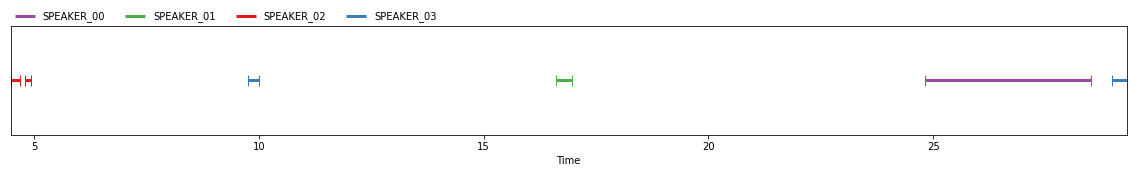

In [14]:
diarization

In [15]:
for turn, _, speaker in diarization.itertracks(yield_label=True):
    print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")

start=4.5s stop=4.7s speaker_SPEAKER_02
start=4.8s stop=4.9s speaker_SPEAKER_02
start=9.8s stop=10.0s speaker_SPEAKER_03
start=16.6s stop=17.0s speaker_SPEAKER_01
start=24.8s stop=28.5s speaker_SPEAKER_00
start=29.0s stop=29.3s speaker_SPEAKER_03


Nice! As we can see the result preserve the same level of accuracy!